In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, roc_auc_score
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

##df = pd.read_csv("C:/Users/sonam/PycharmProjects/ExamPred/kaggle/input/students-exam-scores/Expanded_data_with_more_features.csv")
df = pd.read_csv("C:/Users/tabas/OneDrive-VanierCollege/Documents/GitHub/ExamPred/kaggle/input/students-exam-scores/Expanded_data_with_more_features.csv")
df.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           30641 non-null  int64  
 1   Gender               30641 non-null  object 
 2   EthnicGroup          28801 non-null  object 
 3   ParentEduc           28796 non-null  object 
 4   LunchType            30641 non-null  object 
 5   TestPrep             28811 non-null  object 
 6   ParentMaritalStatus  29451 non-null  object 
 7   PracticeSport        30010 non-null  object 
 8   IsFirstChild         29737 non-null  object 
 9   NrSiblings           29069 non-null  float64
 10  TransportMeans       27507 non-null  object 
 11  WklyStudyHours       29686 non-null  object 
 12  MathScore            30641 non-null  int64  
 13  ReadingScore         30641 non-null  int64  
 14  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(4), object(10)


In [5]:
df.head(3)

,Unnamed: 0,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91


In [6]:
df.drop(df.columns[0], axis=1, inplace=True)
df.head(3)

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  object 
 1   EthnicGroup          28801 non-null  object 
 2   ParentEduc           28796 non-null  object 
 3   LunchType            30641 non-null  object 
 4   TestPrep             28811 non-null  object 
 5   ParentMaritalStatus  29451 non-null  object 
 6   PracticeSport        30010 non-null  object 
 7   IsFirstChild         29737 non-null  object 
 8   NrSiblings           29069 non-null  float64
 9   TransportMeans       27507 non-null  object 
 10  WklyStudyHours       29686 non-null  object 
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 3.3+ MB


In [8]:
#Nr of siblings can't be a float so, Let's change its type to int
df['NrSiblings'] = df['NrSiblings'].astype(pd.Int64Dtype())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               30641 non-null  object
 1   EthnicGroup          28801 non-null  object
 2   ParentEduc           28796 non-null  object
 3   LunchType            30641 non-null  object
 4   TestPrep             28811 non-null  object
 5   ParentMaritalStatus  29451 non-null  object
 6   PracticeSport        30010 non-null  object
 7   IsFirstChild         29737 non-null  object
 8   NrSiblings           29069 non-null  Int64 
 9   TransportMeans       27507 non-null  object
 10  WklyStudyHours       29686 non-null  object
 11  MathScore            30641 non-null  int64 
 12  ReadingScore         30641 non-null  int64 
 13  WritingScore         30641 non-null  int64 
dtypes: Int64(1), int64(3), object(10)
memory usage: 3.3+ MB


In [9]:
#Checking every unique value in every row
for column in df.drop(['MathScore', 'ReadingScore', 'WritingScore'], axis = 1):
    print(f"{column}: {df[column].unique()}")

Gender: ['female' 'male']
EthnicGroup: [nan 'group C' 'group B' 'group A' 'group D' 'group E']
ParentEduc: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school' nan]
LunchType: ['standard' 'free/reduced']
TestPrep: ['none' nan 'completed']
ParentMaritalStatus: ['married' 'single' 'widowed' nan 'divorced']
PracticeSport: ['regularly' 'sometimes' 'never' nan]
IsFirstChild: ['yes' 'no' nan]
NrSiblings: <IntegerArray>
[3, 0, 4, 1, <NA>, 2, 5, 7, 6]
Length: 9, dtype: Int64
TransportMeans: ['school_bus' nan 'private']
WklyStudyHours: ['< 5' '5 - 10' '> 10' nan]


In [10]:
#Cleaning the data that will not be analyzed
#df.drop(['EthnicGroup', 'ParentEduc', 'TransportMeans'], axis = 1, inplace = True)

#Organizing values
df.Gender = df.Gender.map({'female': 0, 'male': 1})
df.TestPrep = df.TestPrep.map({'none': 0, 'completed':1})
df.IsFirstChild = df.IsFirstChild.map({'no': 0, 'yes':1})
df.WklyStudyHours = df.WklyStudyHours.map({'< 5': 'Less than 5 h', '5 - 10': 'Between 5-10 h', '> 10':'More than 10 h'})
df.TransportMeans = df.TransportMeans.map({'private': 0,'school_bus': 1})
df['TestPrep'] = df['TestPrep'].fillna(0)
df.head(10)


,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,NaN,bachelor's degree,standard,0.0,married,regularly,1.0,3,1.0,Less than 5 h,71,71,74
1,0,group C,some college,standard,0.0,married,sometimes,1.0,0,NaN,Between 5-10 h,69,90,88
2,0,group B,master's degree,standard,0.0,single,sometimes,1.0,4,1.0,Less than 5 h,87,93,91
3,1,group A,associate's degree,free/reduced,0.0,married,never,0.0,1,NaN,Between 5-10 h,45,56,42
4,1,group C,some college,standard,0.0,married,sometimes,1.0,0,1.0,Between 5-10 h,76,78,75
5,0,group B,associate's degree,standard,0.0,married,regularly,1.0,1,1.0,Between 5-10 h,73,84,79
6,0,group B,some college,standard,1.0,widowed,never,0.0,1,0.0,Between 5-10 h,85,93,89
7,1,group B,some college,free/reduced,0.0,married,sometimes,1.0,1,0.0,More than 10 h,41,43,39
8,1,group D,high school,free/reduced,1.0,single,sometimes,0.0,3,0.0,More than 10 h,65,64,68
9,0,group B,high school,free/reduced,0.0,married,regularly,1.0,<NA>,0.0,Less than 5 h,37,59,50


In [11]:
#Checking how much null values do we have
df.isnull().sum()

Gender                    0
EthnicGroup            1840
ParentEduc             1845
LunchType                 0
TestPrep                  0
ParentMaritalStatus    1190
PracticeSport           631
IsFirstChild            904
NrSiblings             1572
TransportMeans         3134
WklyStudyHours          955
MathScore                 0
ReadingScore              0
WritingScore              0
dtype: int64

In [12]:
# Using 'mode' to fill null values for categorical & binary columns
df['EthnicGroup'] = df['EthnicGroup'].fillna(df['EthnicGroup'].mode()[0])
df['WklyStudyHours'] = df['WklyStudyHours'].fillna(df['WklyStudyHours'].mode()[0])
df['ParentEduc'] = df['ParentEduc'].fillna(df['ParentEduc'].mode()[0])
df['ParentMaritalStatus'] = df['ParentMaritalStatus'].fillna(df['ParentMaritalStatus'].mode()[0])
df['IsFirstChild'] = df['IsFirstChild'].fillna(df['IsFirstChild'].mode()[0])
df['PracticeSport'] = df['PracticeSport'].fillna(df['PracticeSport'].mode()[0])
df['TestPrep'] = df['TestPrep'].fillna(df['TestPrep'].mode()[0])
df['TransportMeans'] = df['TransportMeans'].fillna(df['TransportMeans'].mode()[0])

#Using for numerical column
df['NrSiblings'] = df['NrSiblings'].interpolate()


In [13]:
df.isnull().sum()

Gender                 0
EthnicGroup            0
ParentEduc             0
LunchType              0
TestPrep               0
ParentMaritalStatus    0
PracticeSport          0
IsFirstChild           0
NrSiblings             0
TransportMeans         0
WklyStudyHours         0
MathScore              0
ReadingScore           0
WritingScore           0
dtype: int64

In [14]:
df.describe()

,Gender,TestPrep,IsFirstChild,NrSiblings,TransportMeans,MathScore,ReadingScore,WritingScore
count,30641.000000,30641.000000,30641.000000,30641.0,30641.00000,30641.000000,30641.000000,30641.000000
mean,0.496622,0.324891,0.652263,2.147498,0.62919,66.558402,69.377533,68.418622
std,0.499997,0.468342,0.476260,1.440607,0.48303,15.361616,14.758952,15.443525
min,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,10.000000,4.000000
25%,0.000000,0.000000,0.000000,1.0,0.00000,56.000000,59.000000,58.000000
50%,0.000000,0.000000,1.000000,2.0,1.00000,67.000000,70.000000,69.000000
75%,1.000000,1.000000,1.000000,3.0,1.00000,78.000000,80.000000,79.000000
max,1.000000,1.000000,1.000000,7.0,1.00000,100.000000,100.000000,100.000000


In [15]:
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,group C,bachelor's degree,standard,0.0,married,regularly,1.0,3.0,1.0,Less than 5 h,71,71,74
1,0,group C,some college,standard,0.0,married,sometimes,1.0,0.0,1.0,Between 5-10 h,69,90,88
2,0,group B,master's degree,standard,0.0,single,sometimes,1.0,4.0,1.0,Less than 5 h,87,93,91
3,1,group A,associate's degree,free/reduced,0.0,married,never,0.0,1.0,1.0,Between 5-10 h,45,56,42
4,1,group C,some college,standard,0.0,married,sometimes,1.0,0.0,1.0,Between 5-10 h,76,78,75


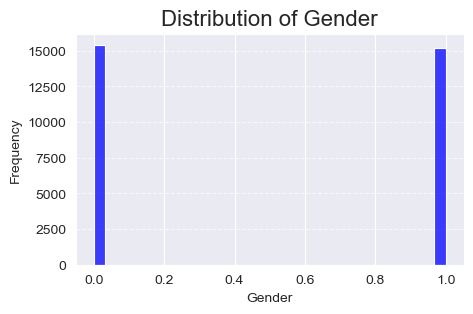

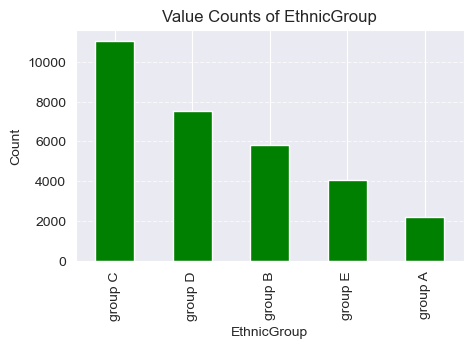

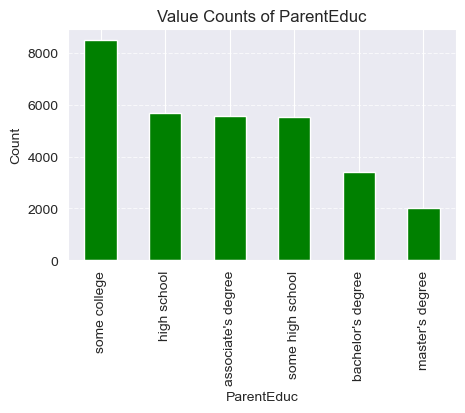

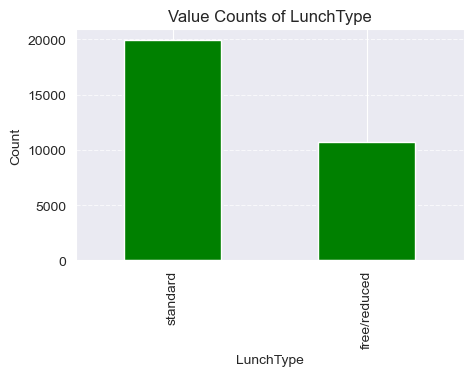

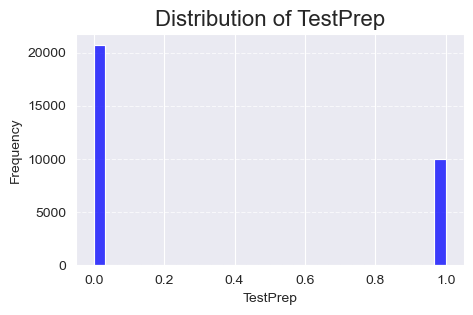

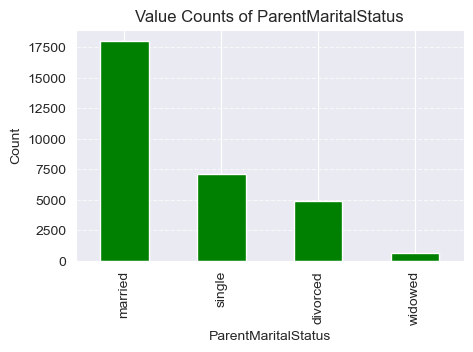

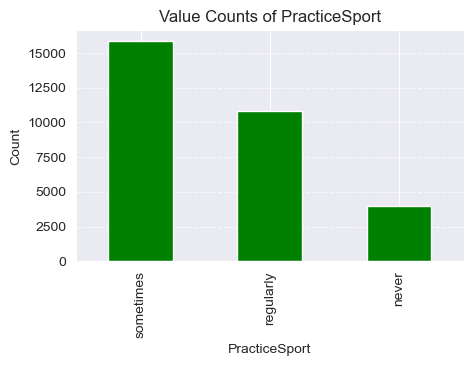

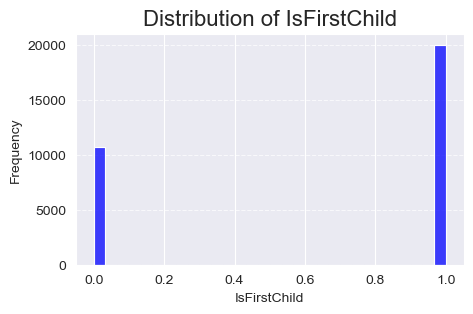

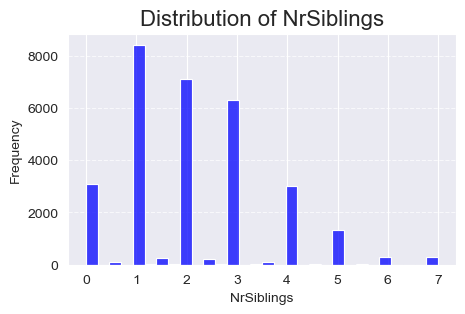

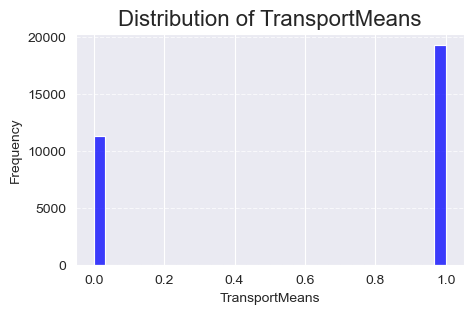

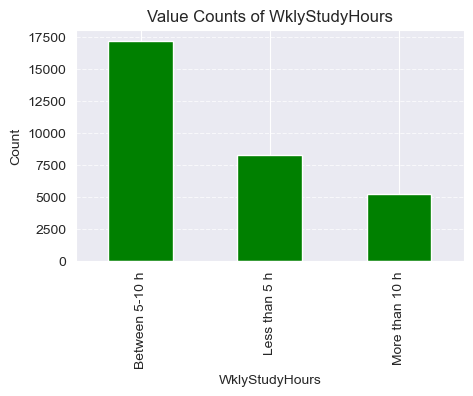

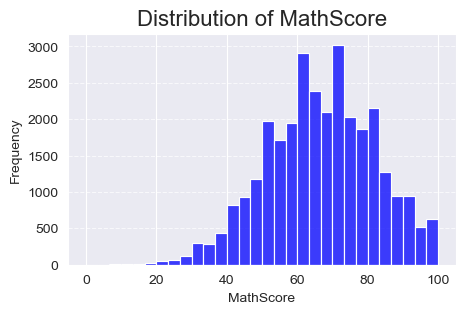

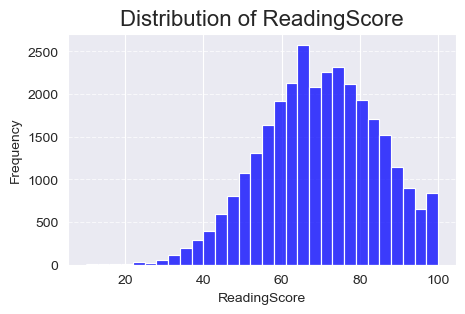

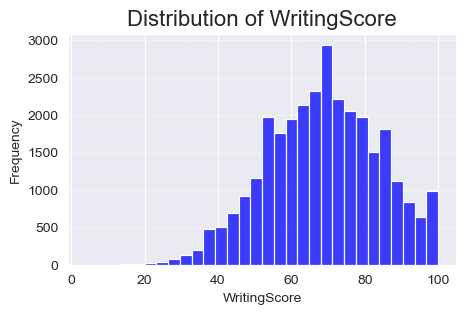

In [16]:
for column in df.columns:
        plt.figure(figsize=(5, 3))
        if pd.api.types.is_numeric_dtype(df[column]):
            # Histogram for numerical values
            sns.histplot(df[column], kde=False, bins=30, color='blue')
            plt.title(f'Distribution of {column}', fontsize=16)
            plt.xlabel(column, fontsize=10)
            plt.ylabel('Frequency', fontsize=10)
        else:
            # Histogram for categorical values
            df[column].value_counts().plot(kind='bar', color='green')
            plt.title(f'Value Counts of {column}', fontsize=12)
            plt.xlabel(column, fontsize=10)
            plt.ylabel('Count', fontsize=10)
            
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()


In [17]:
#transform categories into numerical data so it can better work with classification or regression 
def perform_one_hot_encoding(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)
    return df

data = df.copy()

for column in ['Gender', 'EthnicGroup', 'LunchType', 'ParentMaritalStatus', 'WklyStudyHours']:
    data = perform_one_hot_encoding(data, column)


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ParentEduc                     30641 non-null  object 
 1   TestPrep                       30641 non-null  float64
 2   PracticeSport                  30641 non-null  object 
 3   IsFirstChild                   30641 non-null  float64
 4   NrSiblings                     30641 non-null  Float64
 5   TransportMeans                 30641 non-null  float64
 6   MathScore                      30641 non-null  int64  
 7   ReadingScore                   30641 non-null  int64  
 8   WritingScore                   30641 non-null  int64  
 9   Gender_0                       30641 non-null  bool   
 10  Gender_1                       30641 non-null  bool   
 11  EthnicGroup_group A            30641 non-null  bool   
 12  EthnicGroup_group B            30641 non-null 

In [19]:
#Dummying categorical variables

categoricals = df.select_dtypes(include='object')

dummies = pd.get_dummies(categoricals,drop_first=True)

df = pd.concat([df.drop(categoricals, axis = 1), dummies], axis=1)

In [20]:
#data1 = perform_one_hot_encoding(data1, 'Gender')
# Separate features and target
X = df.drop('MathScore', axis=1)
y = df['MathScore']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{model_name} Performance Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.2f}")
    
    return rmse, mae, r2

In [21]:
# Initialize models
models = {
    'Linear Regression': LinearRegression()
}


In [22]:
# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = evaluate_model(y_test, y_pred, name)

    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    print(f"Cross-validation R2 scores: {cv_scores}")
    print(f"Mean CV R2 score: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})") 


Training Linear Regression...

Linear Regression Performance Metrics:
RMSE: 5.45
MAE: 4.36
R2 Score: 0.87
Cross-validation R2 scores: [0.87486098 0.87501401 0.87723009 0.87041558 0.87308956]
Mean CV R2 score: 0.87 (+/- 0.00)


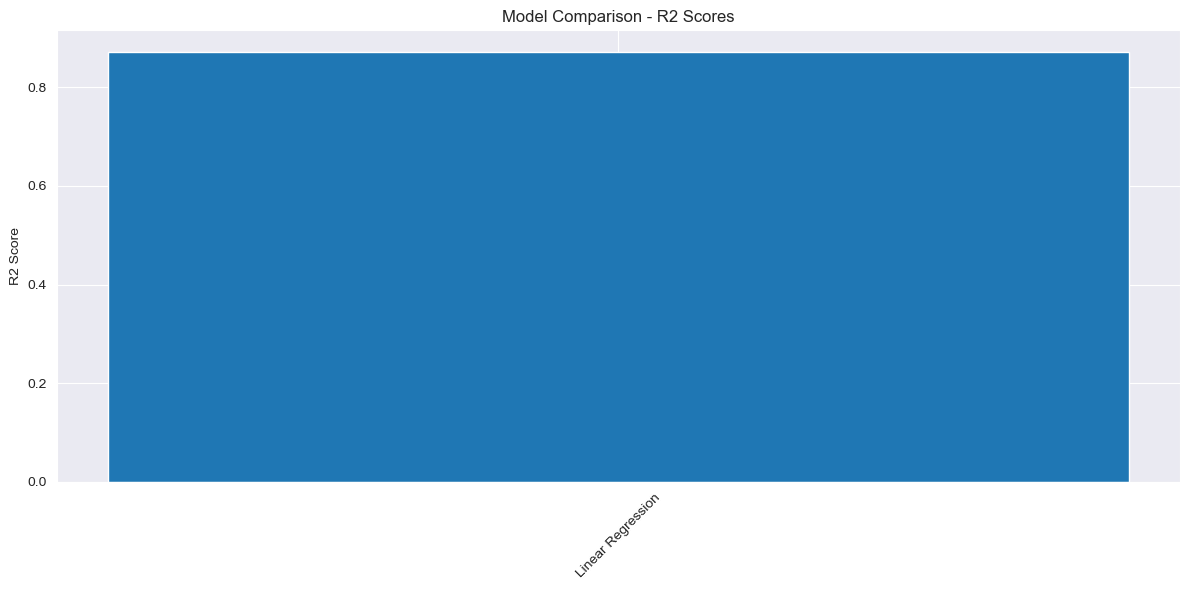

In [23]:
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
r2_scores = [results[name][2] for name in model_names]

plt.bar(model_names, r2_scores)
plt.title('Model Comparison - R2 Scores')
plt.xticks(rotation=45)
plt.ylabel('R2 Score')
plt.tight_layout()
plt.show()

In [24]:
import joblib
joblib.dump(models['Linear Regression'], 'linear_regression_math_score.pkl')